In [5]:
import numpy as np

from emukit.test_functions.multi_fidelity import multi_fidelity_branin_function
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import LatinDesign

from sklearn.metrics import mean_squared_error, r2_score

In [6]:
from collections import namedtuple

Function = namedtuple('Function', ['name', 'y_scale', 'noise_level', 'do_x_scaling', 'num_data', 'fcn'])

branin = Function(name='branin', y_scale=1, noise_level=[0., 0., 0.], do_x_scaling=False, num_data=[80, 30, 10], 
                    fcn=multi_fidelity_branin_function)

In [7]:
def generate_data(fcn_tuple, n_test_points):
    """
    Generates train and test data for
    """
    
    # A different definition of the parameter space for the branin function was used in the paper
    if fcn_tuple.name == 'branin':
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace([ContinuousParameter('x1', -5., 0.), ContinuousParameter('x2', 10., 15.)])
    else:
        fcn, space = fcn_tuple.fcn()
        new_space = ParameterSpace(space._parameters[:-1])
    
    do_x_scaling = fcn_tuple.do_x_scaling
    
    
    # Generate training data
    
    latin = LatinDesign(new_space)
    X = [latin.get_samples(n) for n in fcn_tuple.num_data]
    
    # Scale X if required
    if do_x_scaling:
        scalings = X[0].std(axis=0)
    else:
        scalings = np.ones(X[0].shape[1])
        
    for x in X:
        x /= scalings
    
    Y = []
    for i, x in enumerate(X):
        Y.append(fcn.f[i](x * scalings))
    
    y_scale = fcn_tuple.y_scale
    
    # scale y and add noise if required
    noise_levels = fcn_tuple.noise_level
    if any([n > 0 for n in noise_levels]):
        for y, std_noise in zip(Y, noise_levels):
            y /= y_scale + std_noise * np.random.randn(y.shape[0], 1)
    
    # Generate test data
    x_test = latin.get_samples(n_test_points)
    x_test /= scalings
    y_test = fcn.f[-1](x_test * scalings)
    y_test /= y_scale

    i_highest_fidelity = (len(fcn_tuple.num_data) - 1) * np.ones((x_test.shape[0], 1))
    x_test = np.concatenate([x_test, i_highest_fidelity], axis=1)
    print(X[1].shape)
    return x_test, y_test, X, Y

In [8]:
def calculate_metrics(y_test, y_mean_prediction, y_var_prediction):
    # R2
    r2 = r2_score(y_test, y_mean_prediction)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_mean_prediction))
    # Test log likelihood
    mnll = -np.sum(scipy.stats.norm.logpdf(y_test, loc=y_mean_prediction, scale=np.sqrt(y_var_prediction)))/len(y_test)
    return {'r2': r2, 'rmse': rmse, 'mnll': mnll}

In [282]:
np.random.seed(123)

x_test, y_test, X, Y = generate_data(branin, 1000)

(30, 2)


In [283]:
X[0].shape, Y[0].shape

((80, 2), (80, 1))

In [284]:
X[1].shape, Y[1].shape

((30, 2), (30, 1))

In [285]:
X[2].shape, Y[2].shape

((10, 2), (10, 1))

In [286]:
x_test.shape, y_test.shape

((1000, 3), (1000, 1))

In [287]:
print(x_test[0:15])

[[-4.8325 13.7975  2.    ]
 [-3.4175 11.2275  2.    ]
 [-3.4775 10.8875  2.    ]
 [-3.9025 10.4475  2.    ]
 [-3.1625 12.6675  2.    ]
 [-4.8425 13.0825  2.    ]
 [-0.3775 14.2025  2.    ]
 [-0.1925 13.4525  2.    ]
 [-2.2375 10.3825  2.    ]
 [-0.4875 14.5475  2.    ]
 [-0.0775 12.8175  2.    ]
 [-1.4775 13.6225  2.    ]
 [-3.9375 11.5375  2.    ]
 [-3.3725 12.7925  2.    ]
 [-0.3675 10.5075  2.    ]]


## Introduce AR1 model and fit all three fidelities of data

In [288]:
from emukit.examples.multi_fidelity_dgp.baseline_model_wrappers import LinearAutoRegressiveModel

m1 =  LinearAutoRegressiveModel(X, Y)
m1.optimize()

Optimization restart 1/10, f = -343.5485140738341
Optimization restart 2/10, f = -343.5485147086077
Optimization restart 3/10, f = -343.5485147440106
Optimization restart 4/10, f = -343.54851440211814
Optimization restart 5/10, f = -343.548513919607
Optimization restart 6/10, f = -343.5485123853232
Optimization restart 7/10, f = -343.5485110649246
Optimization restart 8/10, f = -343.5485095239152
Optimization restart 9/10, f = -343.54851309075843
Optimization restart 10/10, f = -343.54851442071214
Optimization restart 1/10, f = -347.6872849459901
Optimization restart 2/10, f = -347.68732649413437
Optimization restart 3/10, f = -346.0946025645288
Optimization restart 4/10, f = -346.0948604673432
Optimization restart 5/10, f = -347.6873290404436
Optimization restart 6/10, f = -347.68710088828857
Optimization restart 7/10, f = -347.68679223994127
Optimization restart 8/10, f = -346.0948181943676
Optimization restart 9/10, f = -346.0948440550005
Optimization restart 10/10, f = -347.6873159

In [289]:
y_mean, y_var = m1.predict(x_test)

import scipy.stats

print(calculate_metrics(y_test, y_mean, y_var))

{'r2': 0.9970478911109587, 'rmse': 0.011164426415574706, 'mnll': -3.691304798717162}


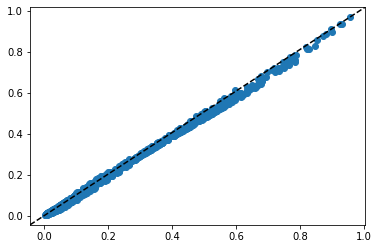

In [290]:
import matplotlib.pyplot as plt

plt.scatter(y_mean,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

## To set up the data in three-layer structure
### Cheap data, expensive data, high data

In [291]:
X_branin_cheap = X[0]
X_branin_expensive = X[1]
X_branin_high = X[2]

y_branin_cheap = Y[0]
y_branin_expensive = Y[1]
y_branin_high = Y[2]

import GPy
from GPy.kern import Kern
from GPy import Param, Model

m2 = GPy.models.GPRegression(X_branin_cheap, y_branin_cheap)
m2.optimize()

 /Users/felix/opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fc5c85e7b10>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7fc5c85e14d0>]}

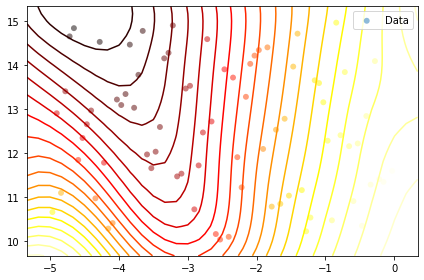

In [292]:
m2.plot()

In [293]:
print(m2)


Name : GP regression
Objective : -205.71136382204776
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       0.545177655271929  |      +ve      |        
  rbf.lengthscale          |       1.716010624033931  |      +ve      |        
  Gaussian_noise.variance  |  1.2989771296387394e-05  |      +ve      |        


In [294]:
m2.kern.variance[0], m2.kern.lengthscale[0]

(0.545177655271929, 1.716010624033931)

### predicting the expensive data using gp trained with cheap data

In [295]:
muA, vA = m2.predict(X_branin_expensive, full_cov = True)

### Set up the kernel matrix using posterior mean and covariance in mu_A and cov_A

In [296]:
from MFRBF import MFRBF

kMF_A = MFRBF(input_dim=X_branin_expensive.shape[1], variance = 5, lengthscale = 1, mu = muA, v=vA)

In [297]:
kRBF_A = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_A = kMF_A * kRBF_A

m_A = GPy.models.GPRegression(X_branin_expensive, y_branin_expensive, k_A)

m_A.optimize()

In [298]:
print(m_A)


Name : GP regression
Objective : -3.9207326763137806
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.MFRBF.variance       |     4.21047386167465  |               |        
  mul.MFRBF.lengtscale     |   1.3485059767483227  |               |        
  mul.rbf.variance         |  0.12244379168648663  |      +ve      |        
  mul.rbf.lengthscale      |   4.1785243911768815  |      +ve      |        
  Gaussian_noise.variance  |  0.05819004252800335  |      +ve      |        


### Now it is going to get the posterior for x_high

In [299]:
def predict_eff(CovMtx, Y):
    len_expensive = Y.shape[0]
    len_all = CovMtx.shape[0]
    len_high = len_all-len_expensive
    K_ee = CovMtx[len_high:,len_high:]
    K_e = CovMtx[0:len_high,len_high:]
    K_inv = np.linalg.inv(K_ee+0.000001*np.eye(len_expensive))
    pred_mu = np.matmul(np.matmul(K_e, K_inv), Y)
    pred_v = CovMtx[0:len_high,0:len_high] - np.matmul(np.matmul(K_e, K_inv), np.matrix.transpose(K_e))
    return pred_mu, pred_v

In [300]:
s1=m_A.kern.rbf.variance[0]
l1=m_A.kern.rbf.lengthscale[0]
s2=m_A.kern.MFRBF.variance[0]
l2=m_A.kern.MFRBF.lengthscale[0]

In [301]:
s1, l1, s2, l2

(0.12244379168648663, 4.1785243911768815, 4.21047386167465, 1.3485059767483227)

In [302]:
Xnew = np.vstack((X_branin_high,X_branin_expensive))

In [303]:
Xnew.shape

(40, 2)

In [304]:
mu1, v1 = m2.predict(Xnew, full_cov = True)

In [305]:
mu1.shape, v1.shape

((40, 1), (40, 40))

In [306]:
kMF_tmp = MFRBF(input_dim=X_branin_high.shape[1],variance = s2, lengthscale = l2, mu = mu1, v=v1)
kRBF_tmp = GPy.kern.RBF(input_dim = X_branin_high.shape[1], variance = s1, lengthscale = l1)
M1 = kMF_tmp.K(Xnew)
M2 = kRBF_tmp.K(Xnew)
GG = np.multiply(M1, M2)
    
pred_mu, pred_cov = predict_eff(GG, y_branin_expensive)

In [307]:
pred_mu.shape, pred_cov.shape

((10, 1), (10, 10))

### Start of training the high layer (3rd layer)

In [308]:
kMF_B = MFRBF(input_dim=X_branin_expensive.shape[1], variance = 2, lengthscale = 1, mu = pred_mu, v=pred_cov)

In [309]:
kRBF_B = GPy.kern.RBF(input_dim = X_branin_expensive.shape[1])

k_B = kMF_B * kRBF_B

m_B = GPy.models.GPRegression(X_branin_high, y_branin_high, k_B)

m_B.optimize()

In [310]:
print(m_B)


Name : GP regression
Objective : 2.7636396108071426
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  mul.MFRBF.variance       |  0.09530391472126265  |               |        
  mul.MFRBF.lengtscale     |   1.0476099026755166  |               |        
  mul.rbf.variance         |   0.1770554516053688  |      +ve      |        
  mul.rbf.lengthscale      |   1.6216686028992606  |      +ve      |        
  Gaussian_noise.variance  |  0.14319712547068372  |      +ve      |        


In [311]:
sb1=m_B.kern.rbf.variance[0]
lb1=m_B.kern.rbf.lengthscale[0]
sb2=m_B.kern.MFRBF.variance[0]
lb2=m_B.kern.MFRBF.lengthscale[0]

In [312]:
sb1, lb1, sb2, lb2

(0.1770554516053688,
 1.6216686028992606,
 0.09530391472126265,
 1.0476099026755166)

## Final stage: prediction the high-level 

In [313]:
X_test = x_test[:,0:2]
X_test.shape
#Y_test=[]
#Y_test_std = []
#Y_test_up=[]
#Y_test_down=[]

#for i in range(X_test.shape[0]):
#    xx = X_test[i].reshape(1,2)
#    Xnew = np.vstack((xx,X_currin_expensive))
#    mu1, v1 = m4.predict(Xnew, full_cov = True)
#    kernMF = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu1, v=v1)
#    kernRBF = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)
#    M1 = kernMF.K(Xnew)
#    M2 = kernRBF.K(Xnew)
#    GG = np.multiply(M1, M2)
    
#    pred_mu, pred_std = predict_eff(GG, y_currin_expensive)
    
#    Y_test.append(pred_mu)
#    Y_test_std.append(pred_std)
#    Y_test_up.append(pred_mu+1.96*pred_std)
#    Y_test_down.append(pred_mu-1.96*pred_std)

(1000, 2)

In [314]:
Xnew1 = np.vstack((X_test,X_branin_high,X_branin_expensive))
Xnew1.shape

(1040, 2)

In [315]:
mu12_1, cov12_1 = m2.predict(Xnew1,full_cov=True)

In [316]:
mu12_1.shape, cov12_1.shape

((1040, 1), (1040, 1040))

In [317]:
kernMF12_1 = MFRBF(input_dim=2,variance = s2, lengthscale = l2, mu = mu12_1, v=cov12_1)
kernRBF12_1 = GPy.kern.RBF(input_dim = 2, variance = s1, lengthscale = l1)

M1_12_1 = kernMF12_1.K(Xnew1)
M2_12_1 = kernRBF12_1.K(Xnew1)
GG12_1 = np.multiply(M1_12_1, M2_12_1)
    
mu12_2, cov12_2 = predict_eff(GG12_1, y_branin_expensive)

In [318]:
mu12_2.shape, cov12_2.shape

((1010, 1), (1010, 1010))

In [319]:
Xnew2 = np.vstack((X_test,X_branin_high))

kernMF12_2 = MFRBF(input_dim=2,variance = sb2, lengthscale = lb2, mu = mu12_2, v=cov12_2)
kernRBF12_2 = GPy.kern.RBF(input_dim = 2, variance = sb1, lengthscale = lb1)

M1_12_2 = kernMF12_2.K(Xnew2)
M2_12_2 = kernRBF12_2.K(Xnew2)
GG12_2 = np.multiply(M1_12_2, M2_12_2)
    
mu12_3, cov12_3 = predict_eff(GG12_2, y_branin_high)

In [320]:
mu12_3.shape, cov12_3.shape

((1000, 1), (1000, 1000))

In [321]:
GG12_2.shape

(1010, 1010)

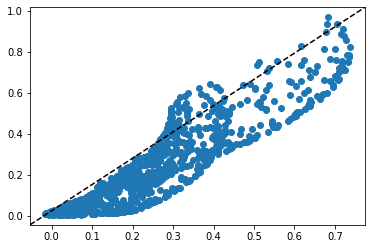

In [322]:
plt.scatter(mu12_3,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.show()

In [323]:
var12_3 = np.diagonal(cov12_3)

In [324]:
print(calculate_metrics(y_test, mu12_3, var12_3))

{'r2': 0.8120230348342923, 'rmse': 0.08908868453460315, 'mnll': 8313.501592334334}


In [235]:
#var12_3[var12_3>0]